In [6]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
import os
os.chdir('C:\\Projects\\ature')
import sys
import numpy as np
import itertools as itr
from random import shuffle
from commons.segmentation import AtureTest
from PIL import Image as IMG
from commons.IMAGE import Image, MatImage
from commons.accumulator import Accumulator
import cv2
import preprocess.utils.filter_utils as filutils


SK_THRESHOLD_PARAMS = np.arange(40, 61, 20)
ALPHA_PARAMS = np.arange(5, 7, 0.5)
GABOR_CONTRIBUTION_PARAMS = np.arange(0.6, 1.1, 0.2)
SEGMENTATION_THRESHOLD_PARAMS = np.arange(9, 15, 0.5)

PARAMS_ITR = itr.product(SK_THRESHOLD_PARAMS, ALPHA_PARAMS, GABOR_CONTRIBUTION_PARAMS, SEGMENTATION_THRESHOLD_PARAMS)

PARAMS_COMBINATION = list(PARAMS_ITR)
shuffle(PARAMS_COMBINATION)

keys = ('sk_threshold', 'alpha', 'gabor_contrib', 'seg_threshold')

all_params = list(dict(zip(keys, param)) for param in PARAMS_COMBINATION)

params = {'sk_threshold': 60,
          'alpha': 6.5,
          'gabor_contrib': 0.8,
          'seg_threshold': 9}

In [2]:
### DRIVE dataset
data_file_path = 'C:\\Projects\\ature\\data\\DRIVE\\test\\images'
mask_path = 'C:\\Projects\\ature\\data\\DRIVE\\test\\mask'
ground_truth_path = 'C:\\Projects\\ature\\data\\DRIVE\\test\\1st_manual'
mask_suffix =  '_test_mask.gif'
ground_truth_suffix = '_manual1.gif'
input_image = '19_test.tif'

In [3]:
%load_ext autoreload
%autoreload 2

In [10]:
def get_mask_file(file_name): return file_name.split('_')[0] + mask_suffix
def get_ground_truth_file(file_name): return file_name.split('_')[0] + ground_truth_suffix

img_obj = Image()

img_obj.load_file(data_dir=data_file_path, file_name=input_image)
img_obj.load_mask(mask_dir=mask_path, fget_mask=get_mask_file, erode=True)
img_obj.load_ground_truth(gt_dir=ground_truth_path, fget_ground_truth=get_ground_truth_file)

img_obj.working_arr = img_obj.image_arr[:, :, 1]
img_obj.apply_mask()

img_obj.apply_bilateral()
img_obj.apply_gabor()
img_obj.generate_lattice_graph(eight_connected=False)

accumulator = Accumulator(img_obj=img_obj)

Mask loaded: 19_test_mask.gif
Ground truth loaded: 19_manual1.gif
"apply_bilateral(__)" ... took 0.144 seconds
"apply_gabor(__)" ... took 1.094 seconds
"generate_lattice_graph(__)" ... took 4.405 seconds


In [29]:
### Run for image files with in-time mask erosion
tester = AtureTest(out_dir='out')
acc = tester.run(params=params, save_images=False, epochs=1, alpha_decay=0.4, accumulator=accumulator)
# tester.run_all(params_combination=all_params)

Running epoch: 0
"create_skeleton(__)" ... took 0.016 seconds
"run_segmentation(__)" ... took 58.511 seconds
Number of params combination tried: 1


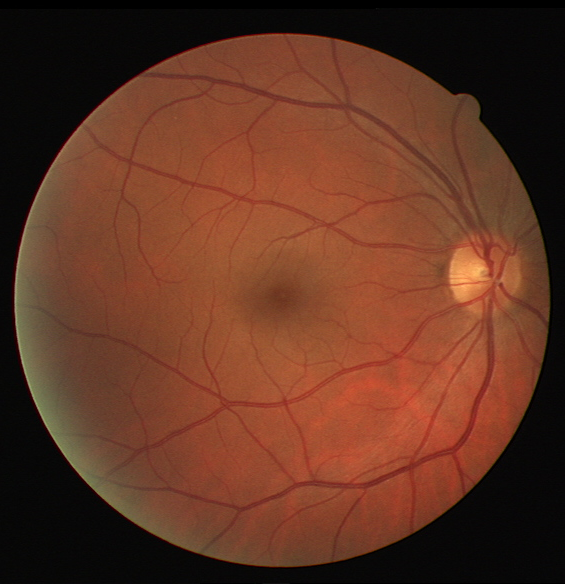

In [30]:
IMG.fromarray(img_obj.image_arr)

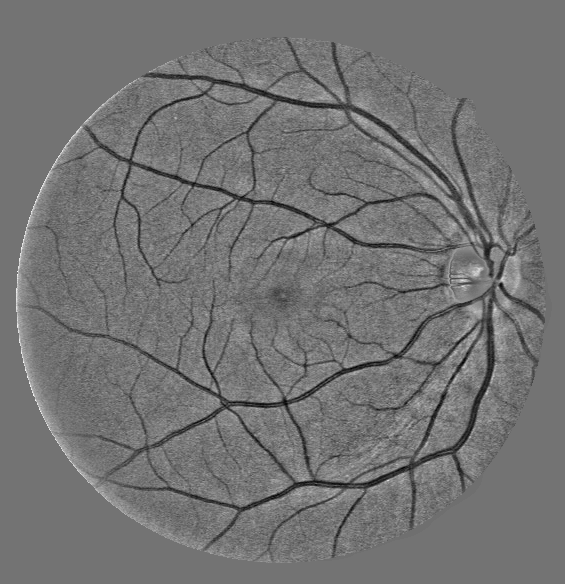

In [31]:
IMG.fromarray(img_obj.diff_bilateral)

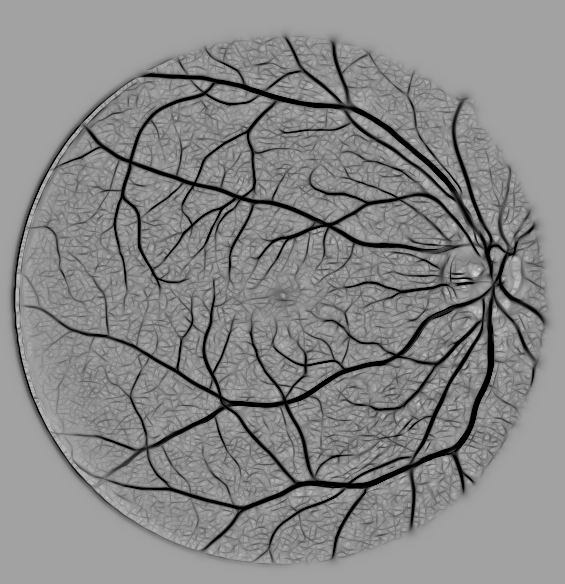

In [32]:
IMG.fromarray(img_obj.img_gabor)

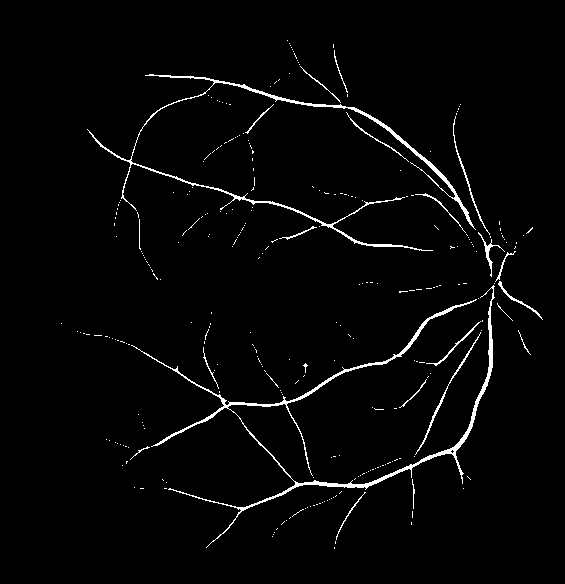

In [33]:
IMG.fromarray(255-acc.res['skeleton0'])

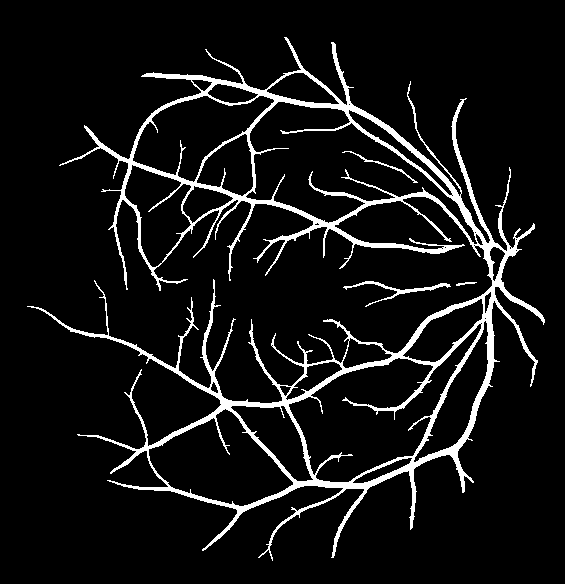

In [34]:
IMG.fromarray(acc.res['segmented0'])

In [35]:
print(acc.res['scores0'])

{'Precision': 0.8676659030015921, 'Recall': 0.8163749954331226, 'Accuracy': 0.9744393259789065, 'F1': 0.8412393645056849}


In [36]:
print(acc.res['params0'])

{'sk_threshold': 60, 'alpha': 6.5, 'gabor_contrib': 0.8, 'seg_threshold': 9}


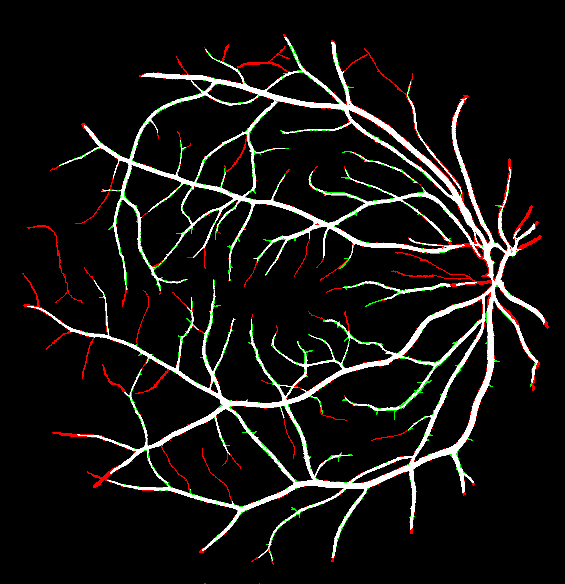

In [37]:
IMG.fromarray(acc.res['segmented_rgb0'])

In [38]:
import preprocess.utils.img_utils as ig

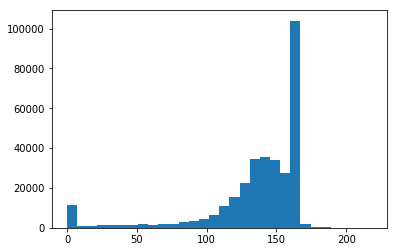

In [39]:
ig.histogram(acc.img_obj.img_gabor, bins=30)

In [40]:
fni = np.full(acc.arr_2d.shape, 250, dtype=np.uint8)
for i in range(fni.shape[0]):
    for j in range(fni.shape[1]):
        if acc.arr_2d[i,j] == 0 and acc.img_obj.ground_truth[i,j] == 255:
            fni[i, j] = acc.img_obj.img_gabor[i,j]

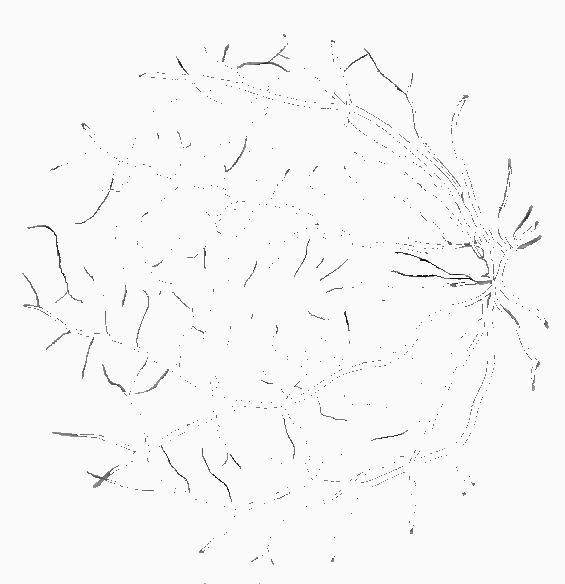

In [41]:
IMG.fromarray(fni)